# Set up

In [2]:
import glob
import datetime as dt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import pytz
import pprint

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Model data

## Review features

In [7]:
flights3=pd.read_pickle('./data/flights3.pkl')

In [8]:
flights3['DEP_TIME_F']=flights3['DEP_TIME'].astype('float64')

### Feature engineering

Lambda: -26.28452888097318


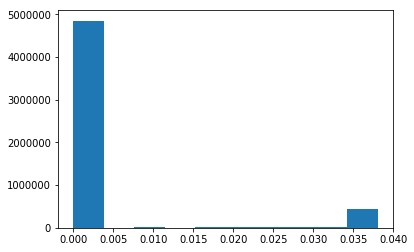

In [9]:
lamb=stats.boxcox_normmax(flights3['Precip']-flights3['Precip'].min()+1, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(flights3['Precip']-flights3['Precip'].min()+1,lamb)-1)/lamb

plt.hist(y_t);

flights3['Precip_bx']=y_t


Lambda: -0.6212217504155624


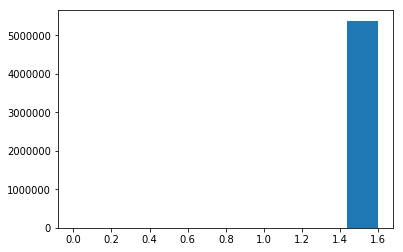

In [10]:
lamb=stats.boxcox_normmax(flights3['INBOUND_DELAY']-flights3['INBOUND_DELAY'].min()+1, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(flights3['INBOUND_DELAY']-flights3['INBOUND_DELAY'].min()+1,lamb)-1)/lamb

plt.hist(y_t);

flights3['INBOUND_DELAY_bx']=y_t

In [9]:
flights3['DEP_DELAY'].size

5374990

### Pick features to use

In [11]:
flights4=flights3[['DEP_DELAY', 'INBOUND_DELAY_bx', 'TURNAROUND_TIME', 'ORIG_FLIGHTS_DEPART_VOL', 
                   'DEP_TIME_F','Precip_bx', 'Temp_F']]

#### OLS

In [12]:
# check stats using statsmodel OLS
smaller_df=flights4.sample(n=10000)
X_s=smaller_df.iloc[:,1:]
y_s=smaller_df.iloc[:,0]

model = sm.OLS(y_s, sm.add_constant(X_s))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     332.4
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        10:13:34   Log-Likelihood:                -49864.
No. Observations:               10000   AIC:                         9.974e+04
Df Residuals:                    9993   BIC:                         9.979e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -4500.1485    112.327    -40.063      0.000   -4720.332   -4279.965
INBOUND_DELAY_bx         2897.9233     72.501     39.971      0.000    2755.807    3040.040
TURNAROUND_TIME             0.0376      0.013      2.864      0.004       0.012       0.063
ORIG_FLIGHTS_DEPART_VOL -9.922e-08   3.19e-06     -0.031      0.975   -6.35e-06    6.15e-06
DEP_TIME_F                  0.0109      0.001     14.832      0.000       0.009       0.012
Precip_bx                 108.3795     32.810      3.303      0.001      44.065     172.694
Temp_F                      0.0161      0.021      0.762      0.446      -0.025       0.058
==============================================================================
Omnibus:                    15303.566   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12457061.089
Skew:                           9.398   Prob(JB):                         0.00
Kurtosis:                     174.883   Cond. No.                     7.14e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.14e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Perform train/val split

In [13]:
#X=flights4.iloc[:,1:]
#y=flights4.iloc[:,0]
sampled=flights4.sample(n=50000)
X=sampled.iloc[:,1:]
y=sampled.iloc[:,0]
print(X.shape)
print(y.shape)

(50000, 6)
(50000,)


(array([4.8655e+04, 1.1360e+03, 1.4900e+02, 2.6000e+01, 1.1000e+01,
        9.0000e+00, 5.0000e+00, 3.0000e+00, 5.0000e+00, 1.0000e+00]),
 array([ -35. ,  106.6,  248.2,  389.8,  531.4,  673. ,  814.6,  956.2,
        1097.8, 1239.4, 1381. ]),
 <a list of 10 Patch objects>)

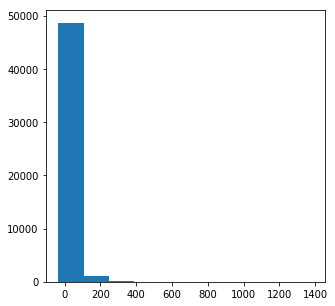

In [1212]:
plt.hist(y)

### Split into Train, Validatie, Test Sets

In [14]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

### Run pipelines for various regression CV models

In [15]:
def modelResults(model, test_set_pred, y_test):
    r2_test = r2_score(y_test, test_set_pred)
    print('R2 is: '+str(r2_test))
    print('Alpha is: '+str(model.alpha_))
    pprint.pprint(list(zip(X_test.columns, model.coef_)))
    
    data=pd.DataFrame()
    data['predict']=test_set_pred
    data['resid']=y_test - data.predict
    with sns.axes_style('white'):
        #plot=data.plot(kind='scatter',
        #          x='predict',y='resid',alpha=0.2,figsize=(10,6))
        sns.jointplot(x="predict", y="resid", data=data)
    
    df=pd.concat([data['resid'], X_train_val], axis=1)

    sns.jointplot(x="INBOUND_DELAY", y="resid", data=df)
    
    fig = plt.figure()
    stats.probplot(data['resid'], dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.show()
    

R2 is: 0.15956404837714722
Alpha is: 81.11308307896873
[('INBOUND_DELAY_bx', 15.822087462674421),
 ('TURNAROUND_TIME', 0.40823221534248744),
 ('ORIG_FLIGHTS_DEPART_VOL', -0.06672722992138805),
 ('DEP_TIME_F', 5.218470893845108),
 ('Precip_bx', 1.4324037928710942),
 ('Temp_F', 0.0044947694479828834)]


ValueError: Could not interpret input 'INBOUND_DELAY'

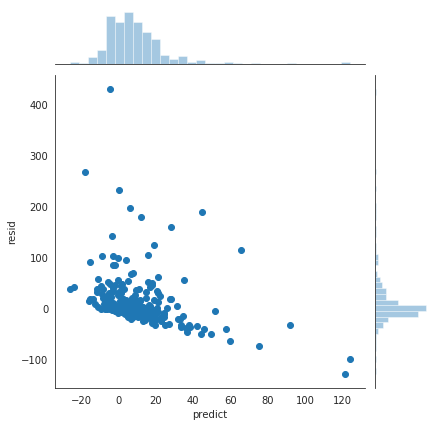

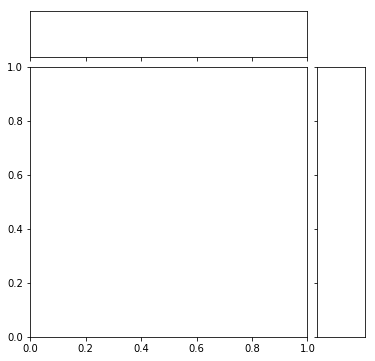

In [16]:
# RidgeCV Results
# set up alpha vector 
alphavec= 10**np.linspace(1,7,100)

steps = [('standardize', StandardScaler()), 
         ('ridgeCV', RidgeCV(alphas = alphavec, cv=5))]

pipe = Pipeline(steps)
pipe.fit(X_train_val.values, y_train_val)
test_set_pred = pipe.predict(X_train_val.values)

modelResults(pipe.named_steps['ridgeCV'], test_set_pred, y_train_val)

R2 is: 0.16672553709126692
Alpha is: 0.01663816886076129
[('INBOUND_DELAY', 14.6444892354412),
 ('TURNAROUND_TIME', 0.91218443630457),
 ('ORIG_FLIGHTS_DEPART_VOL', -0.3127541198493543),
 ('DEP_TIME_F', 5.5936347602098),
 ('Precip', 1.8152687102157001),
 ('Temp_F', -0.36851536909953037)]


/Users/pyt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


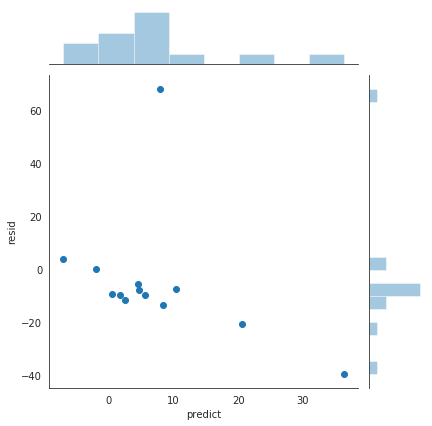

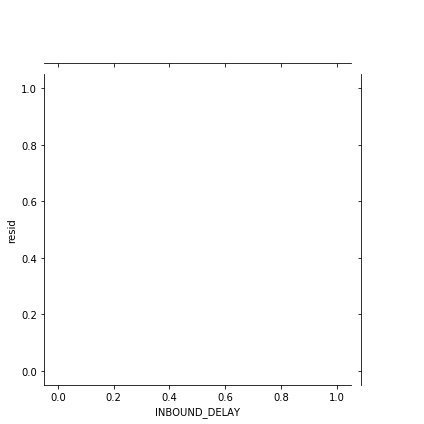

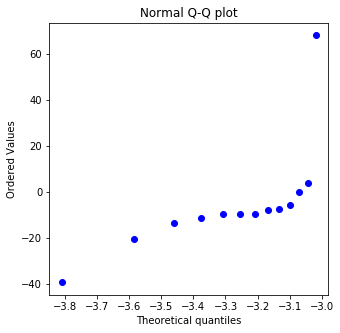

In [1268]:
# LassoCV Results
# set up alpha vector 
alphavec = 10**np.linspace(-2,2,200)

steps = [('standardize', StandardScaler()), 
         ('LassoCV', LassoCV(alphas = alphavec, cv=5))]

pipe = Pipeline(steps)
pipe.fit(X_train_val.values, y_train_val)
test_set_pred = pipe.predict(X_test.values)

modelResults(pipe.named_steps['LassoCV'], test_set_pred, y_test)

R2 is: 0.030138529726059793
Alpha is: 10.0
[('INBOUND_DELAY', 1.6834188038976023),
 ('TURNAROUND_TIME', 0.0),
 ('ORIG_FLIGHTS_DEPART_VOL', 0.0),
 ('DEP_TIME_F', 0.1830392695613033),
 ('Precip', 0.0),
 ('Temp_F', 0.0)]


/Users/pyt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


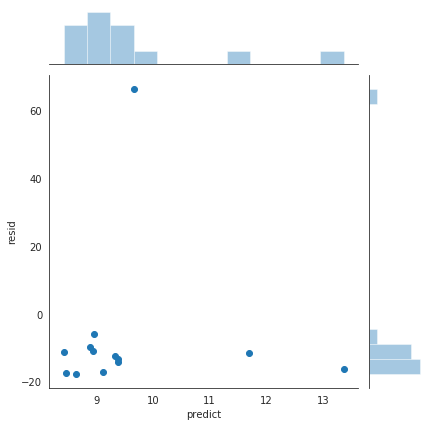

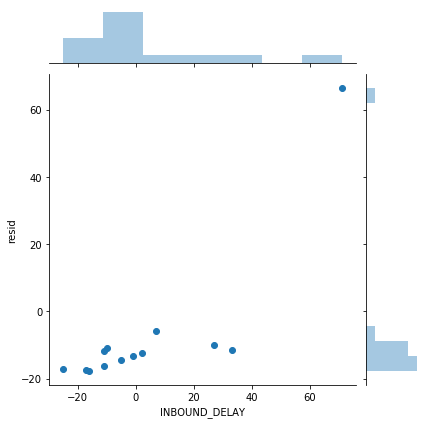

In [1261]:
# ElasticNetCV Results 
steps = [('standardize', StandardScaler()), 
         ('ElasticNetCV', ElasticNetCV(alphas = alphavec, cv=5))]

pipe = Pipeline(steps)
pipe.fit(X_train_val.values, y_train_val)
test_set_pred = pipe.predict(X_test.values)

modelResults(pipe.named_steps['ElasticNetCV'], test_set_pred, y_test)

### Use cross_val_score

#### Linear Regression

In [1188]:
lm = LinearRegression()
cross_val_score(lm, X_train_val, y_train_val, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.28295989, 0.24956175, 0.25194583, 0.27564733, 0.23114669])

#### Poly Regression

In [1189]:
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X.values)

lm_poly = LinearRegression()

cross_val_score(lm_poly, X_poly, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.30367349, 0.30238662, 0.34522142, 0.34819392, 0.27395995])

## Check assumptions

### Check for correlations

In [874]:
flights4.describe()

,DEP_DELAY,INBOUND_DELAY,TURNAROUND_TIME,ORIG_FLIGHTS_DEPART_VOL,DEP_TIME_F,Precip,Temp_F,WindSpeed
count,4.355976e+06,4.355976e+06,4.355976e+06,4.355976e+06,4.355976e+06,4.355976e+06,4.355976e+06,4.355976e+06
mean,-7.057337e-01,-5.595315e+00,2.620751e+00,1.523776e+05,1.324043e+03,9.245625e-02,6.053306e+01,8.096860e+00
std,7.939802e+00,1.573706e+01,4.318680e+00,1.138881e+05,4.849360e+02,6.317674e-01,1.715527e+01,4.643937e+00
min,-1.300000e+01,-2.020000e+02,-1.821667e+01,2.080000e+02,0.000000e+00,0.000000e+00,-3.202000e+01,0.000000e+00
25%,-6.000000e+00,-1.500000e+01,7.000000e-01,5.742700e+04,9.230000e+02,0.000000e+00,4.922500e+01,4.619231e+00
50%,-3.000000e+00,-8.000000e+00,1.000000e+00,1.513340e+05,1.316000e+03,0.000000e+00,6.200000e+01,7.521154e+00
75%,1.000000e+00,2.000000e+00,1.783333e+00,2.398280e+05,1.728000e+03,0.000000e+00,7.322500e+01,1.095849e+01
max,2.800000e+01,6.800000e+01,2.280000e+01,3.922550e+05,2.359000e+03,4.151000e+01,1.145500e+02,5.248000e+02


In [16]:
smaller_df=flights4.sample(n=10000)

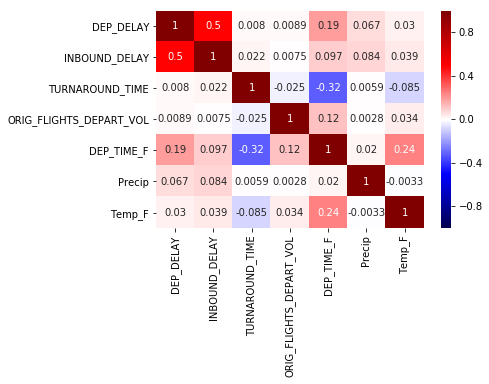

In [17]:
sns.heatmap(smaller_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

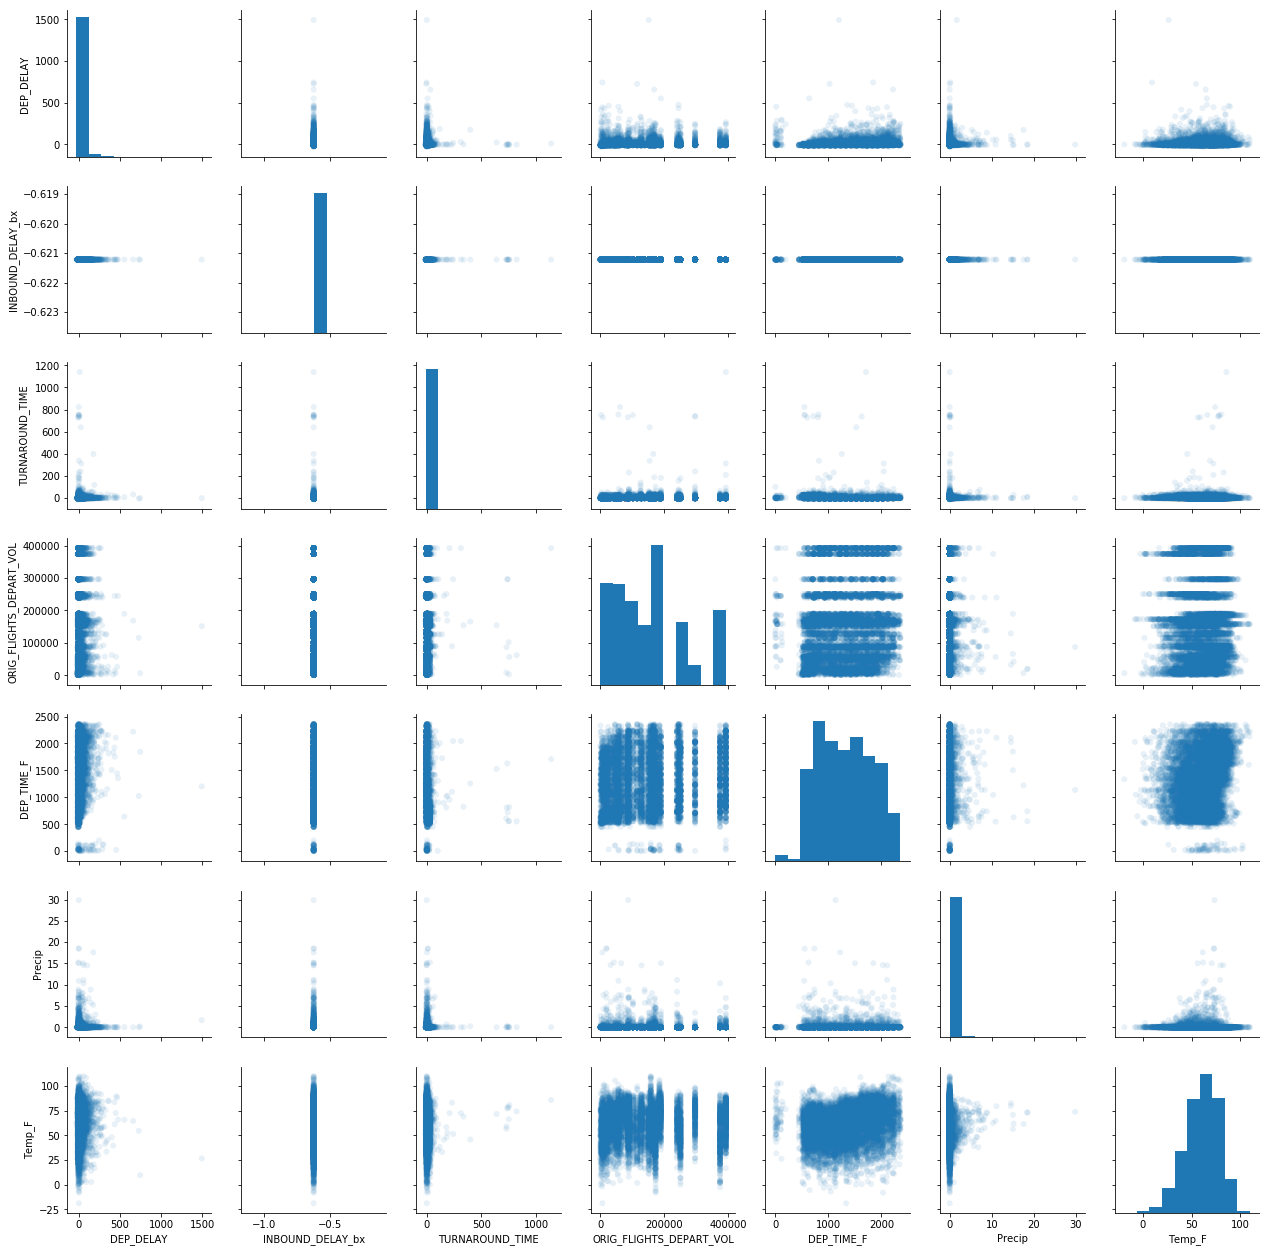

In [1230]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.1, edgecolor='none'))

### Check feature validity

In [1222]:
# check stats using statsmodel
model = sm.OLS(y_train_val, X_train_val)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DEP_DELAY   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     465.0
Date:                Fri, 25 Jan 2019   Prob (F-statistic):               0.00
Time:                        09:07:20   Log-Likelihood:                 74860.
No. Observations:               40000   AIC:                        -1.497e+05
Df Residuals:                   39994   BIC:                        -1.497e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
INBOUND_DELAY_bx           -2.2966      0.001  -1810.401      0.000      -2.299      -2.294
TURNAROUND_TIME          2.425e-05   5.03e-06      4.821      0.000    1.44e-05    3.41e-05
ORIG_FLIGHTS_DEPART_VOL  1.167e-08   1.65e-09      7.059      0.000    8.43e-09    1.49e-08
DEP_TIME_F               1.654e-05   3.86e-07     42.881      0.000    1.58e-05    1.73e-05
Precip                      0.0035      0.000     12.660      0.000       0.003       0.004
Temp_F                   1.218e-05    1.1e-05      1.106      0.269   -9.41e-06    3.38e-05
==============================================================================
Omnibus:                    15718.168   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6207429.519
Skew:                          -0.551   Prob(JB):                         0.00
Kurtosis:                      64.018   Cond. No.                     1.30e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.3e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Index(['DEP_DELAY', 'INBOUND_DELAY', 'TURNAROUND_TIME',
       'ORIG_FLIGHTS_DEPART_VOL', 'DEP_TIME_F', 'Precip', 'Temp_F',
       'WindSpeed'],
      dtype='object')


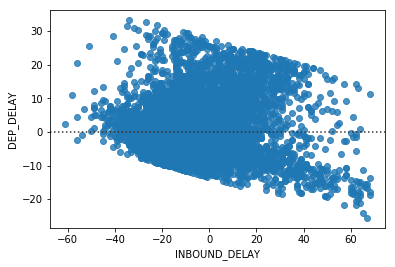

In [893]:
smaller_df=flights4.sample(n=10000)

print(smaller_df.columns)
sns.residplot(x='INBOUND_DELAY', y='DEP_DELAY', data=smaller_df)

### Check prediction plot

In [1194]:
lr = LinearRegression()
fit = lr.fit(X_train_val,y_train_val) # for later use

In [940]:
X_test.shape

(10000, 7)

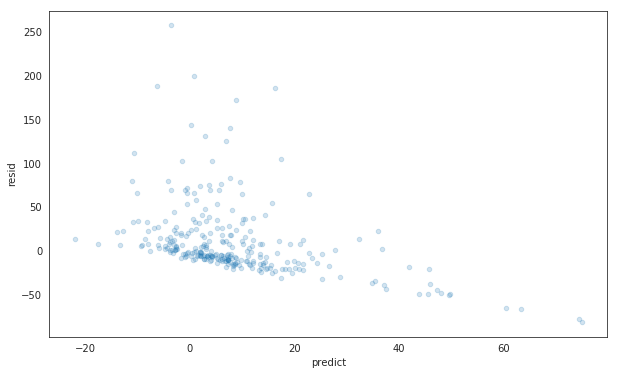

In [1195]:
data=pd.DataFrame()
data['predict']=lr.predict(X_train_val)
data['resid']=y_train_val - data.predict
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

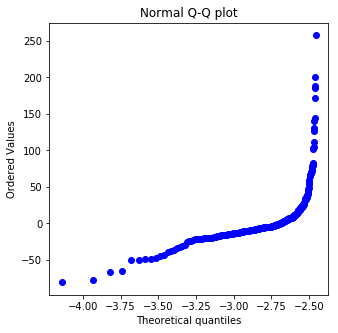

In [1196]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

### Check feature strength in LASSO

In [781]:
from sklearn.linear_model import lars_path

In [1003]:
## Scale the variables
std = StandardScaler()
std.fit(X_s.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [1004]:
X_tr = std.transform(X_s.values)

In [1005]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_s.values, method='lasso')

Computing regularization path using the LARS ...


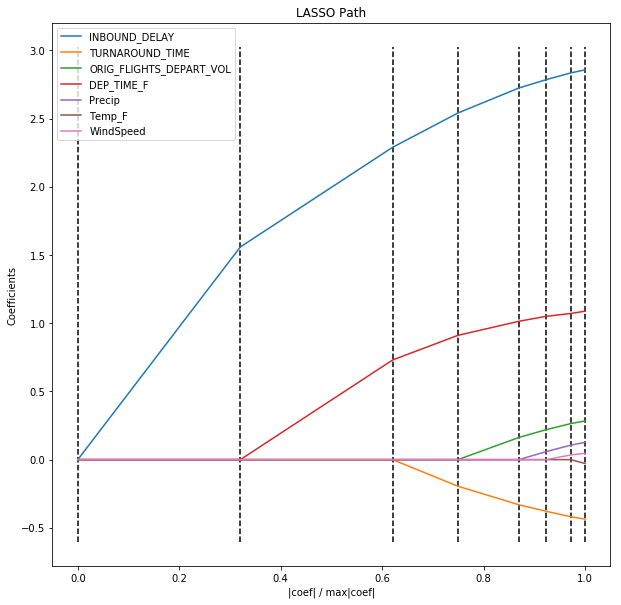

In [1006]:
# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

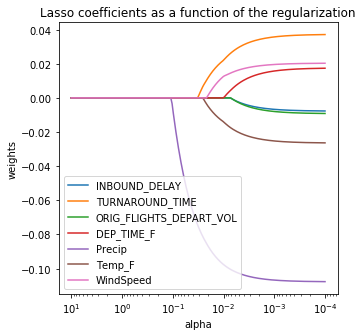

In [1116]:
# #############################################################################
# Compute paths
# X is the 10x10 Hilbert matrix
#X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
#y = np.ones(10)

n_alphas = 200
alphas = 10**np.linspace(-4, 1, 200)
#alphas= 10**np.linspace(-1,7,100)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_tr, y_s)
    coefs.append(lasso.coef_)

# #############################################################################
# Display results

ax = plt.gca()

xx = np.sum(np.abs(np.array(coefs).T), axis=1)

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

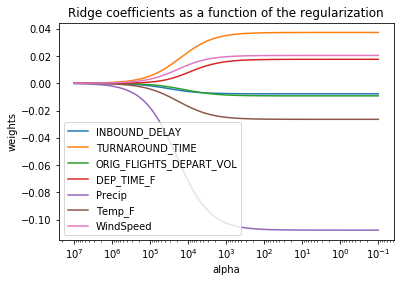

In [1100]:
# #############################################################################
# Compute paths
# X is the 10x10 Hilbert matrix
#X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
#y = np.ones(10)

n_alphas = 100
#alphas = 10**np.logspace(-1, 1, n_alphas)
alphas= 10**np.linspace(-1,7,100)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_tr, y_s)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

xx = np.sum(np.abs(np.array(coefs).T), axis=1)

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

## DUMP yard

### Use KFold to train and test

In [93]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [94]:
count=0
for train_ind, val_ind in kf.split(X,y):
    if count==3:
        break
    count+=1
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple regression scores:  [0.049965150055135577, 0.04896407347368781, 0.04898081914280217]
Ridge scores:  [0.05016222916647617, 0.04915669833780534, 0.049172400833312424] 

Simple mean cv r^2: 0.049 +- 0.000
Ridge mean cv r^2: 0.049 +- 0.000
